In [11]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import Dense,Flatten, GlobalAveragePooling2D
from keras.applications.xception import Xception
import keras
from IPython.display import clear_output
from tqdm import tqdm
import cv2

In [2]:
class TrainingPlot(keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can choose the style of your preference
            plt.style.use("seaborn")
            
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()

plot_losses = TrainingPlot()

In [3]:
# Read the labels csv
labels = pd.read_csv('dataset/labels.csv')

In [4]:
# Find the number of classes
num_classes = len(labels.loc[:,'breed'].unique())
num_classes

120

In [5]:
#Initialize the train x and y
x_train = []
y_train = []

#Define the image size (for resizing)
im_size = 256

# Read the images and labels and append to the train lists
for i, (img_id, breed) in enumerate(tqdm(labels.values)):
    img = cv2.imread('dataset/train/{}.jpg'.format(img_id))
    label = labels.iloc[i,1]
    x_train.append(cv2.resize(img, (im_size, im_size)))
    y_train.append(label)

100%|██████████| 10222/10222 [00:22<00:00, 463.19it/s]


In [6]:
# Convert the x_train to normalized numpy array
x_train_arr = np.array(x_train, np.float32) / 255.

In [7]:
#One hot encode the labels (training y)
y_train_ser = pd.Series(y_train)
one_hot = pd.get_dummies(y_train_ser, sparse=True)
y_train_arr = np.asarray(one_hot, np.uint8)

In [8]:
# Create the train val split
X_train, X_val, Y_train, Y_val = train_test_split(x_train_arr,y_train_arr, test_size=0.2, random_state=1)

In [12]:
def create_and_train_model(MODEL):

    # Define the model to be the ResNet50 with a final FC layer 
    # with nodes equal to number of classes in the dataset
    base_model = MODEL(weights='imagenet', include_top=False, input_shape=(im_size, im_size, 3))

    #Add new top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs = base_model.input, outputs=x)

    #Freeze the base model layers,so that only the added top layers train
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

    model.summary()
    
    model.fit(X_train, Y_train, 
          epochs=25, 
          validation_data = (X_val, Y_val), 
          callbacks=[plot_losses],
          verbose=1)

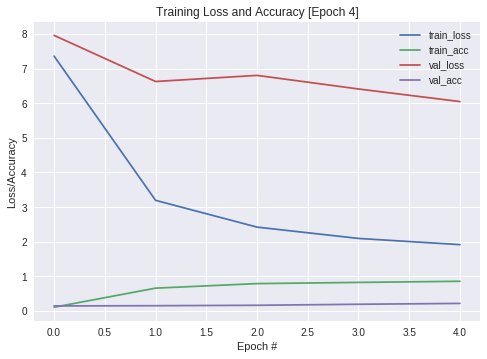

8177/8177 [==============================] - 44s 5ms/step - loss: 1.9177 - acc: 0.8607 - val_loss: 6.0462 - val_acc: 0.2220


In [10]:
create_and_train_model(VGG16)

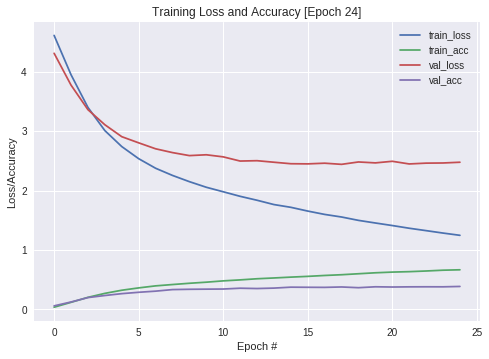

8177/8177 [==============================] - 42s 5ms/step - loss: 1.2464 - acc: 0.6665 - val_loss: 2.4761 - val_acc: 0.3863


In [18]:
create_and_train_model(VGG16)

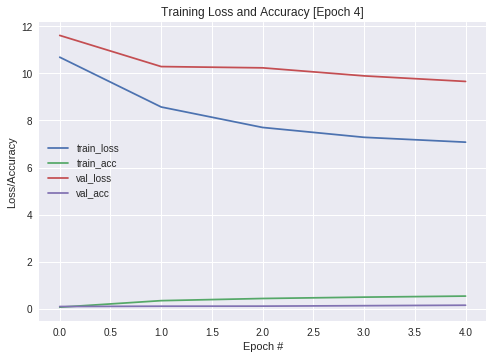

8177/8177 [==============================] - 49s 6ms/step - loss: 7.0760 - acc: 0.5426 - val_loss: 9.6538 - val_acc: 0.1550


In [11]:
create_and_train_model(VGG19)

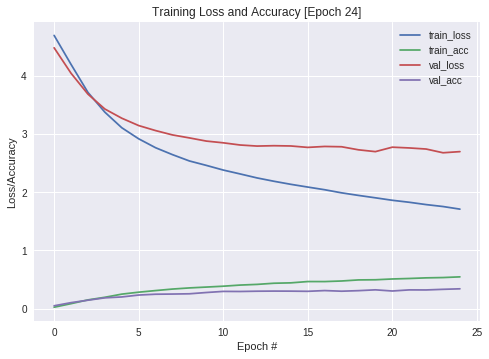

8177/8177 [==============================] - 48s 6ms/step - loss: 1.7082 - acc: 0.5454 - val_loss: 2.6956 - val_acc: 0.3403


In [13]:
create_and_train_model(VGG19)

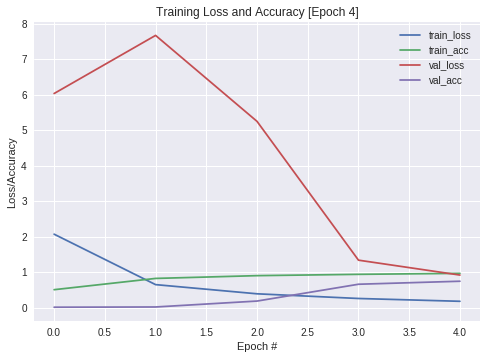

8177/8177 [==============================] - 41s 5ms/step - loss: 0.1764 - acc: 0.9632 - val_loss: 0.9153 - val_acc: 0.7413


In [12]:
create_and_train_model(ResNet50)

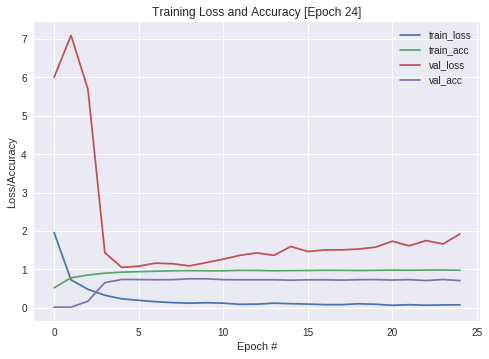

8177/8177 [==============================] - 41s 5ms/step - loss: 0.0738 - acc: 0.9754 - val_loss: 1.9211 - val_acc: 0.7042


In [14]:
create_and_train_model(ResNet50)

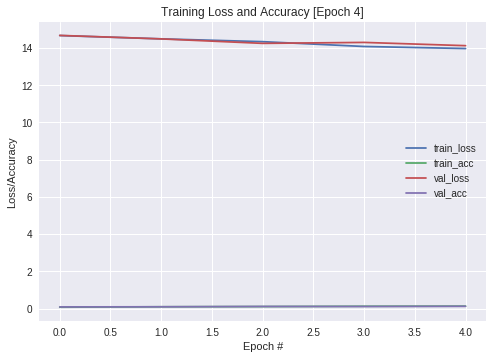

8177/8177 [==============================] - 35s 4ms/step - loss: 13.9648 - acc: 0.1293 - val_loss: 14.1188 - val_acc: 0.1193


In [13]:
create_and_train_model(InceptionV3)

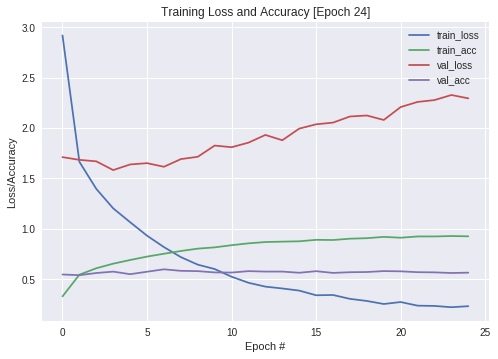

8177/8177 [==============================] - 32s 4ms/step - loss: 0.2326 - acc: 0.9258 - val_loss: 2.2944 - val_acc: 0.5653


In [15]:
create_and_train_model(InceptionV3)

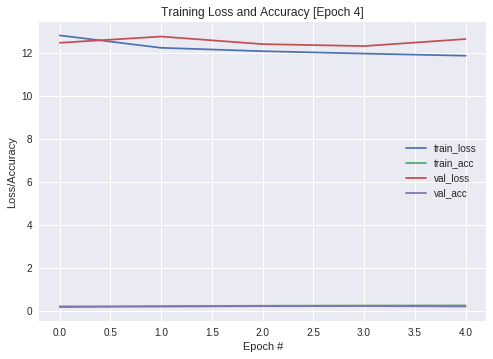

8177/8177 [==============================] - 62s 8ms/step - loss: 11.8685 - acc: 0.2546 - val_loss: 12.6438 - val_acc: 0.2054


In [14]:
create_and_train_model(InceptionResNetV2)

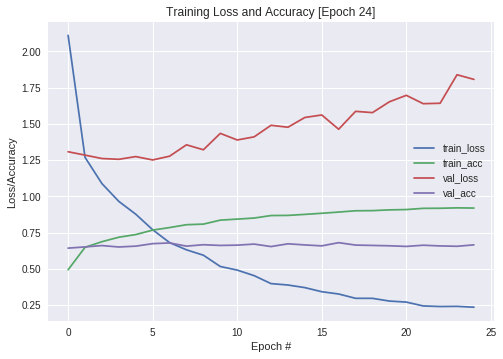

8177/8177 [==============================] - 60s 7ms/step - loss: 0.2350 - acc: 0.9189 - val_loss: 1.8065 - val_acc: 0.6650


In [16]:
create_and_train_model(InceptionResNetV2)

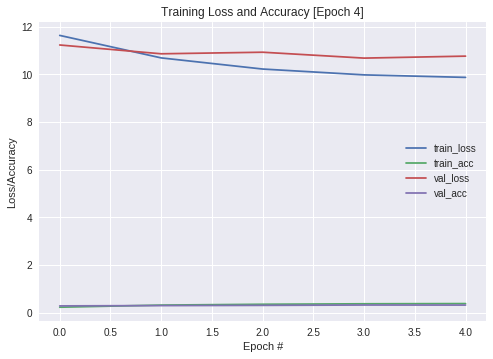

8177/8177 [==============================] - 52s 6ms/step - loss: 9.8719 - acc: 0.3764 - val_loss: 10.7640 - val_acc: 0.3139


In [15]:
create_and_train_model(Xception)

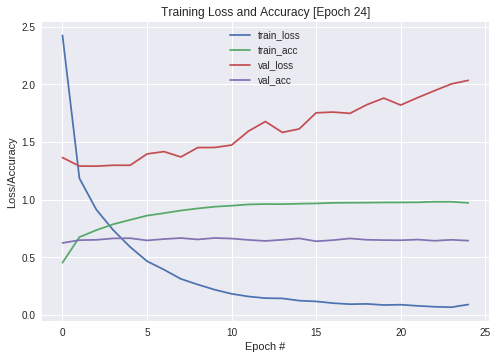

8177/8177 [==============================] - 47s 6ms/step - loss: 0.0909 - acc: 0.9719 - val_loss: 2.0337 - val_acc: 0.6445


In [17]:
create_and_train_model(Xception)